# Evaluate Detectron2 with Custom COCO Datasets

# Clone Mask-RCNN Function


In [1]:
import sys
!git clone https://github.com/ARG-NCTU/Mask-RCNN-Detectron2.git
sys.path.append('/content/Mask-RCNN-Detectron2')

Cloning into 'Mask-RCNN-Detectron2'...
remote: Enumerating objects: 852, done.
remote: Counting objects: 100% (852/852), done.
remote: Compressing objects: 100% (663/663), done.
remote: Total 852 (delta 163), reused 849 (delta 160), pack-reused 0
Receiving objects: 100% (852/852), 35.18 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (163/163), done.


# Install related module

Note : After running the command below , you need to restart the notebook ! and can skip the command below

In [2]:
!pip install -U git+https://github.com/facebookresearch/fvcore.git
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-o_mpzcub
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-o_mpzcub
     |████████████████████████████████| 276kB 9.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=44576 sha256=801c97ba5aa4165490b7c6f8c768f938b4861face316e38eb135d41b8433df5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2zcpoun/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=039705d52937201f2e946075bde68fce74385570d5d2f4ad76f244c56fb6f68d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10508 sha256=213fe9d1cfd209dfab41471e1a1847cc83cc2732dbc9bcc0d7532498d9361b60
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4

# Import Libraries

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os 
import gdown
import torch
import logging
from zipfile import ZipFile

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from google.colab import drive
drive.mount('/content/gdrive')

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



Mounted at /content/gdrive


# Download Datasets

In [2]:
dataset_url = 'https://drive.google.com/u/1/uc?id=1gyom0ysZ3GauPWd26f3_Przw2VK3tXuD&export=download'
dataset_name = 'subt-urban-coco-dataset'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.zip', quiet=False)
    zip1 = ZipFile(dataset_name + '.zip')
    zip1.extractall(dataset_name)
    zip1.close()

print("Finished downloading dataset.")

Downloading...
From: https://drive.google.com/u/1/uc?id=1gyom0ysZ3GauPWd26f3_Przw2VK3tXuD&export=download
To: /content/subt-urban-coco-dataset.zip
132MB [00:00, 207MB/s]


Finished downloading dataset.


# Register your own data set in coco format

In [3]:

from detectron2.data.datasets import register_coco_instances

register_coco_instances('subt_train', {}, 
                        '/content/gdrive/MyDrive/subt_new/train.json', 
                       '/content/gdrive/MyDrive/subt_new/subt_train')
register_coco_instances('subt_val', {}, 
                        '/content/gdrive/MyDrive/subt_new/test.json', 
                       '/content/gdrive/MyDrive/subt_new/subt_test')

In [4]:
subt_metadata = MetadataCatalog.get("subt_val")
dataset_dicts = DatasetCatalog.get("subt_val")
subt_metadata

FileNotFoundError: ignored

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("subt_train",)
cfg.DATASETS.TEST = ("subt_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes

# Download a pre-trained SubT model

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1bc53dQJQMDNAP1hXAHjsUfvTFIA3HFxH&export=download"
models_name = "model_0096989.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.")

Downloading...
From: https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1bc53dQJQMDNAP1hXAHjsUfvTFIA3HFxH&export=download
To: /content/output/model_0096989.pth
351MB [00:06, 50.7MB/s]


Finished downloading models.


Now, let's run inference with the trained model on the validation dataset.
First, let's create a predictor using the model we trained.

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0096989.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("subt_val", )
predictor = DefaultPredictor(cfg)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)

[12/28 07:31:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Then, we randomly select several samples to visualize the prediction results.

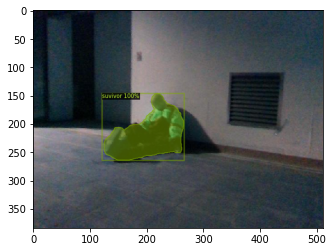

In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
with torch.no_grad():
    evaluator = COCOEvaluator("subt_val", cfg, False, output_dir="./output/")
    val_loader = build_detection_test_loader(cfg, "subt_val")
    inference_on_dataset(trainer.model, val_loader, evaluator)
result = inference_on_dataset(predictor.model, val_loader, evaluator)
print(result)

WARNING [12/28 07:31:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [12/28 07:31:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/28 07:31:13 d2.data.datasets.coco]: Loaded 552 images in COCO format from /content/gdrive/MyDrive/subt_new/test.json
[12/28 07:31:13 d2.data.build]: Distribution of instances among all 5 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |  backpack  | 136          |  suvivor   | 158          |
|     vent     | 144          |   phone    | 114          |            |              |
|    total     | 552          |            |              |            |              |
[12/28 07:31:13 d2.data.dataset_mapper]: [DatasetMapper] Augme

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


[12/28 07:31:17 d2.evaluation.evaluator]: Inference done 11/552. 0.1017 s / img. ETA=0:03:21
[12/28 07:31:23 d2.evaluation.evaluator]: Inference done 23/552. 0.1021 s / img. ETA=0:03:34
[12/28 07:31:28 d2.evaluation.evaluator]: Inference done 36/552. 0.1020 s / img. ETA=0:03:28
[12/28 07:31:33 d2.evaluation.evaluator]: Inference done 49/552. 0.1019 s / img. ETA=0:03:24
[12/28 07:31:38 d2.evaluation.evaluator]: Inference done 61/552. 0.1021 s / img. ETA=0:03:20
[12/28 07:31:43 d2.evaluation.evaluator]: Inference done 74/552. 0.1023 s / img. ETA=0:03:14
[12/28 07:31:48 d2.evaluation.evaluator]: Inference done 86/552. 0.1024 s / img. ETA=0:03:11
[12/28 07:31:54 d2.evaluation.evaluator]: Inference done 100/552. 0.1025 s / img. ETA=0:03:03
[12/28 07:31:59 d2.evaluation.evaluator]: Inference done 114/552. 0.1027 s / img. ETA=0:02:55
[12/28 07:32:04 d2.evaluation.evaluator]: Inference done 128/552. 0.1030 s / img. ETA=0:02:49
[12/28 07:32:09 d2.evaluation.evaluator]: Inference done 140/552. 0

# Run segmentation on a video

SubT Urban Alpha Course Configuration 1 Artifact : https://www.youtube.com/watch?v=T5M1zDDZy24

---


SubT Urban Alpha Course Configuration 2 Artifact : https://www.youtube.com/watch?v=mhNAX1dpl84

---


SubT Urban Beta Course Configuration 1 Artifact : https://www.youtube.com/watch?v=Amb1ghx8IRM

---


SubT Urban Beta Course Configuration 2 Artifact : https://www.youtube.com/watch?v=Eejmchll0l8

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("mhNAX1dpl84", width=500)
display(video)


Download video

In [ ]:
!pip install youtube-dl

In [ ]:
!youtube-dl https://www.youtube.com/watch?v=Eejmchll0l8 -f 22 -o video.mp4


Start predict video

In [ ]:
!python /content/Mask-RCNN-Detectron2/demo/demo.py \
--config-file /content/Mask-RCNN-Detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml \
--video-input video.mp4 --confidence-threshold 0.8 --output /content/MaskRCNN_test0.mp4 \
--opts MODEL.WEIGHTS /content/output/model_0096989.pth MODEL.ROI_HEADS.NUM_CLASSES 5 DATASETS.TEST "('subt_val',)" \

<video controls src="/content/MaskRCNN_test0.mp4"/>


